In [292]:
# !pip install pandas
# !pip install arviz matplotlib
# !pip install pymc3
# !pip install seaborn
# !pip install scikit-learn
# !pip install numpy

In [293]:
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error, r2_score


In [294]:
file_path = 'dataset/data_perikanan.csv'
data = pd.read_csv(file_path)

In [295]:
data['Tanggal Panen'] = pd.to_datetime(data['Tanggal Panen'], format='%m/%d/%Y')

In [296]:
data['Tanggal Penyeburan Benih'] = pd.to_datetime(data['Tanggal Penyeburan Benih'], format='%m/%d/%Y')

In [297]:
# Display the first few rows to understand the structure
data.head()

,no,Jenis Ikan,Jumlah Ikan per Kolam,Jumlah Benih per Kolam,Harga Benih per Kolam (Rp),Harga Benih per Ekor (Rp),Tanggal Penyeburan Benih,Total Pakan per Kolam (sak),Harga Pakan per Kolam (Rp),Harga Pakan per Sak (Rp),Total Hasil Panen (kg),Hasil Panen (Rp),Harga Ikan per kg (Rp),Masa Budidaya (bulan),Tanggal Panen,Berat Ikan per Ekor (gram)
0,1,Ikan Gurame,4000,4000,3600000,900,2023-01-01,88,27720000,315000,1938,45499000,23500,10,2024-11-01,600-800 gram
1,2,Ikan Gurame,4000,4000,4000000,1000,2023-01-03,87,27405000,315000,2134,52230000,24500,10,2023-10-07,600-800 gram
2,3,Ikan Gurami,4000,4000,3600000,900,2023-01-02,88,27720000,315000,1936,45499000,23500,12,2024-01-12,600-800 gram
3,4,Ikan Gurami,4000,4000,3200000,800,2023-03-04,89,28035000,315000,1992,47808000,24000,11,2024-02-07,600-800 gram
4,5,Ikan Gurami,4000,4000,3200000,800,2023-02-03,86,26660000,310000,1900,43700000,23000,12,2024-02-18,600-800 gram


In [298]:
data = data.sort_values(by='Tanggal Penyeburan Benih')

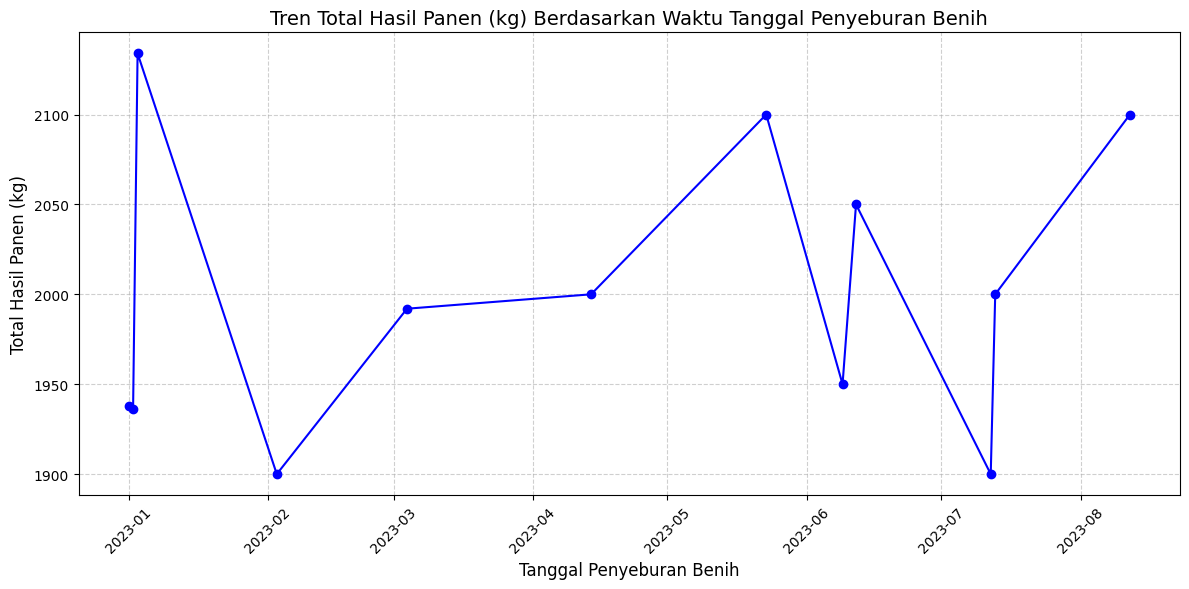

In [299]:
# Plot Total Hasil Panen (kg) berdasarkan Tanggal Penyeburan Benih
plt.figure(figsize=(12, 6))
plt.plot(data['Tanggal Penyeburan Benih'], data['Total Hasil Panen (kg)'], marker='o', linestyle='-', color='b')
plt.title('Tren Total Hasil Panen (kg) Berdasarkan Waktu Tanggal Penyeburan Benih', fontsize=14)
plt.xlabel('Tanggal Penyeburan Benih', fontsize=12)
plt.ylabel('Total Hasil Panen (kg)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

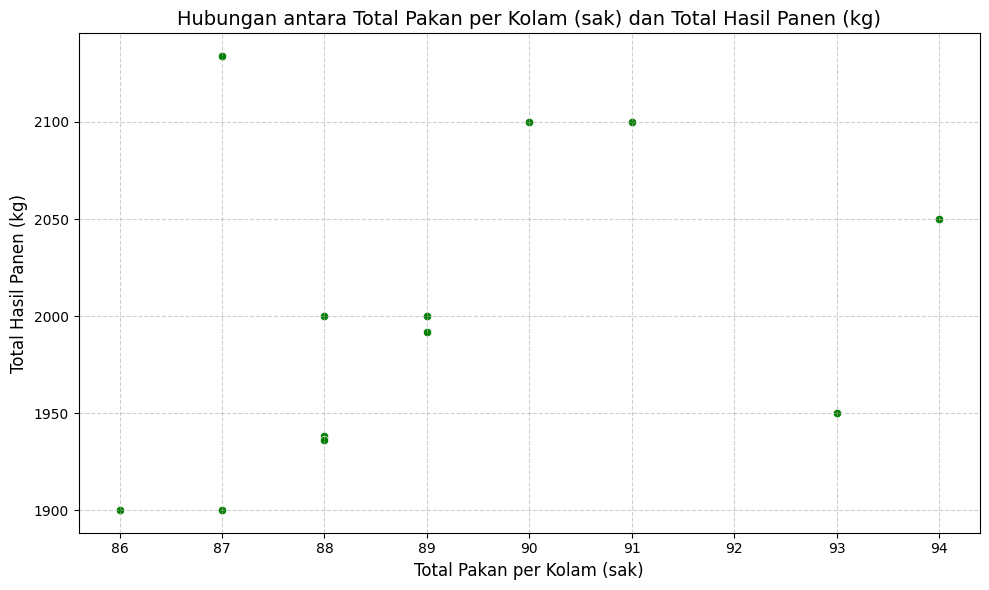

In [300]:
# Plot hubungan antara Total Pakan per Kolam (sak) dengan Total Hasil Panen (kg)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Total Pakan per Kolam (sak)', y='Total Hasil Panen (kg)', color='green')
plt.title('Hubungan antara Total Pakan per Kolam (sak) dan Total Hasil Panen (kg)', fontsize=14)
plt.xlabel('Total Pakan per Kolam (sak)', fontsize=12)
plt.ylabel('Total Hasil Panen (kg)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [301]:
# Mengatasi nilai yang hilang
data = data.dropna()

# Konversi kolom tanggal ke format datetime
data['Tanggal Penyeburan Benih'] = pd.to_datetime(data['Tanggal Penyeburan Benih'], format='%m/%d/%Y')

# Mengkonversi kolom 'Berat Ikan per Ekor (gram)' menjadi float
# Misalnya, "600-800 gram" menjadi rata-rata 700 gram
def convert_berat(berat):
    parts = berat.split('-')
    avg = (int(parts[0]) + int(parts[1].split()[0])) / 2
    return avg

data['Berat Ikan per Ekor (gram)'] = data['Berat Ikan per Ekor (gram)'].apply(convert_berat)

# Tampilkan data setelah preprocessing
print("\nData Setelah Preprocessing:")
print(data.head())



Data Setelah Preprocessing:
   no   Jenis Ikan  Jumlah Ikan per Kolam  Jumlah Benih per Kolam  \
0   1  Ikan Gurame                   4000                    4000   
2   3  Ikan Gurami                   4000                    4000   
1   2  Ikan Gurame                   4000                    4000   
4   5  Ikan Gurami                   4000                    4000   
3   4  Ikan Gurami                   4000                    4000   

   Harga Benih per Kolam (Rp)  Harga Benih per Ekor (Rp)  \
0                     3600000                        900   
2                     3600000                        900   
1                     4000000                       1000   
4                     3200000                        800   
3                     3200000                        800   

  Tanggal Penyeburan Benih  Total Pakan per Kolam (sak)  \
0               2023-01-01                           88   
2               2023-01-02                           88   
1               20

In [302]:
# Fitur yang akan digunakan
fitur = ['Jumlah Ikan per Kolam',
         'Jumlah Benih per Kolam',
         'Harga Benih per Kolam (Rp)',
         'Total Pakan per Kolam (sak)',
         'Harga Pakan per Kolam (Rp)',
         'Masa Budidaya (bulan)',
         'Berat Ikan per Ekor (gram)',
         'Jenis Ikan']

# Variabel target
target = 'Total Hasil Panen (kg)'

# Memisahkan fitur dan target
X = data[fitur]
y = data[target]

# Encoding fitur kategorikal 'Jenis Ikan'
le = LabelEncoder()
X['Jenis Ikan'] = le.fit_transform(X['Jenis Ikan'])

print("\nFitur yang Digunakan:")
print(X.head())



Fitur yang Digunakan:
   Jumlah Ikan per Kolam  Jumlah Benih per Kolam  Harga Benih per Kolam (Rp)  \
0                   4000                    4000                     3600000   
2                   4000                    4000                     3600000   
1                   4000                    4000                     4000000   
4                   4000                    4000                     3200000   
3                   4000                    4000                     3200000   

   Total Pakan per Kolam (sak)  Harga Pakan per Kolam (Rp)  \
0                           88                    27720000   
2                           88                    27720000   
1                           87                    27405000   
4                           86                    26660000   
3                           89                    28035000   

   Masa Budidaya (bulan)  Berat Ikan per Ekor (gram)  Jenis Ikan  
0                     10                       700.0    

C:\Users\Asus\AppData\Local\Temp\ipykernel_17388\514654011.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Jenis Ikan'] = le.fit_transform(X['Jenis Ikan'])


In [303]:
# Membagi data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nJumlah Data Training: {X_train.shape[0]}")
print(f"Jumlah Data Testing: {X_test.shape[0]}")



Jumlah Data Training: 9
Jumlah Data Testing: 3


In [304]:
# Inisialisasi model Bayesian Ridge
model = BayesianRidge()

# Melatih model
model.fit(X_train, y_train)

print("\nModel Bayesian Ridge berhasil dilatih.")


Model Bayesian Ridge berhasil dilatih.



Mean Squared Error (MSE): 5947.32
R-squared (R2): -2.50


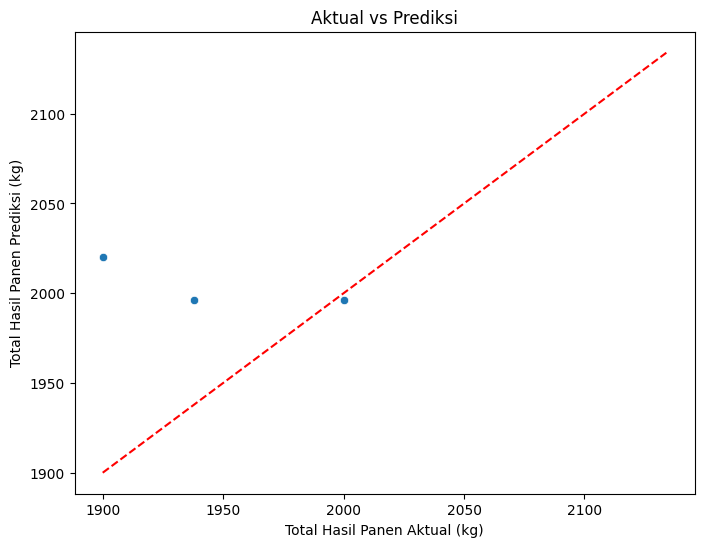

In [305]:
# Melakukan prediksi pada data testing
y_pred = model.predict(X_test)

# Menghitung MSE dan R2 Score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nMean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R2): {r2:.2f}")

# Visualisasi hasil prediksi vs aktual
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Total Hasil Panen Aktual (kg)')
plt.ylabel('Total Hasil Panen Prediksi (kg)')
plt.title('Aktual vs Prediksi')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.show()

In [306]:
# Fungsi untuk melakukan prediksi berdasarkan input pengguna
def prediksi_panen(model, dataset):
    print("Prediksi Panen Berdasarkan Parameter Berikut:")
    
    # Pertanyaan untuk Jumlah Ikan dan Jumlah Benih per Kolam
    jumlah_ikan_benih = int(input("Masukkan jumlah ikan atau benih per kolam: "))
    
    # Pertanyaan untuk Harga Benih per Ekor
    harga_benih_per_ekor = int(input("Masukkan harga benih per ekor (Rp): "))
    harga_total_benih = jumlah_ikan_benih * harga_benih_per_ekor  # Perhitungan total harga benih
    
    # Pertanyaan untuk Total Pakan per Kolam
    total_pakan_per_kolam = int(input("Masukkan total pakan per kolam (sak): "))
    
    # Pertanyaan untuk Harga Pakan per Sak
    harga_pakan_per_sak = int(input("Masukkan harga pakan per sak (Rp): "))
    harga_total_pakan = total_pakan_per_kolam * harga_pakan_per_sak  # Perhitungan total harga pakan
    
    # Pertanyaan untuk Masa Budidaya
    masa_budidaya = int(input("Masukkan masa budidaya (bulan): "))
    
    # Berat Ikan per Ekor diambil rata-rata dari dataset
    berat_ikan_per_ekor = dataset['Berat Ikan per Ekor (gram)'].mean()
    
    # Nilai default untuk kolom lain jika diperlukan (misalnya `Jenis Ikan`)
    jenis_ikan = 0  # Default untuk kolom kategori yang tidak perlu diubah
    fitur_tambahan = 0  # Misalnya placeholder untuk fitur yang tidak digunakan
    
    # Membuat array data untuk prediksi (8 fitur)
    data_prediksi = np.array([[jumlah_ikan_benih, harga_total_benih, total_pakan_per_kolam,
                               harga_total_pakan, masa_budidaya, berat_ikan_per_ekor, jenis_ikan, fitur_tambahan]])
    
    # Prediksi hasil panen
    hasil_panen = model.predict(data_prediksi)
    print(f"\nPrediksi Total Hasil Panen (kg): {hasil_panen[0]:.2f} kg")


# Memanggil fungsi prediksi
prediksi_panen(model, data)


Prediksi Panen Berdasarkan Parameter Berikut:

Prediksi Total Hasil Panen (kg): 1753.84 kg


C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but BayesianRidge was fitted with feature names
  warnings.warn(
